<a href="https://colab.research.google.com/github/giraffe009/Machine_Learning_5G_NR/blob/master/exp02_KPIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the library, authenticate, and create the interface to google Sheets.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure the font size for the figure
#SMALL_SIZE = 12
#MEDIUM_SIZE = 14
#BIGGER_SIZE = 16
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# Input

In [0]:
SINR_dB = np.arange(-10,40.1, step=0.1)  # SINR value for each bit
print(SINR_dB.size, SINR_dB[0], SINR_dB[-1])
#SINR_dB

501 -10.0 39.99999999999982


# Computing BEP, SEP, BLEP and Throughput for SISO under AWGN Channel

## Functions for computing BER

In [0]:
# import libraries:
import numpy as np
from scipy.special import erfc, comb
from scipy.integrate import quad


# functions:


def fun_gen_weights_psk(M):

    k = np.log2(M).astype(int)  # number of bits per symbol
    str1 = '0' + str(k) + 'b'  # string for formatting
    v_int = np.arange(M)  # symbol integer vector
    v_bit = [format(k0, str1) for k0 in v_int]  # symbol bit vector
    
    v_bit2 = np.zeros((M,k),dtype=int)
    for k1 in range(M):
        for k2 in range(k):
            v_bit2[k1,k2] = int(v_bit[k1][k2])
    
    sym_map = v_int ^ (v_int >> 1) # convert binary to gray coding
    
    z = v_bit2[sym_map]
    w = np.sum(z, 1)

    wsym = np.hstack ((w[1:M//2] + np.flipud(w[M//2+1:M]), w[M//2]))
    return wsym/k


def f (x_, gamma_, g_mod) : 
    return np.exp( -1 * gamma_ *g_mod / (np.sin(x_))**2 )


def f_psk_1(x_, gamma_, M, k, i):
    """Integrand function for PSK"""
    return np.exp(-1 * gamma_ * (np.sin((2*i-1)*np.pi/M))**2 / (sin(x_))**2)


def f_psk_2(x_, gamma_, M, k, i):
    """Integrand function for PSK"""
    return np.exp(-1 * gamma_ * (np.sin((2*i+1)*np.pi/M))**2 / (sin(x_))**2)


def fun_ber_awgn(EbN0dB, mod='qam', M=4, data_enc=None):
    """
    fun_ber_awgn computes the symbol error probability for AWGN channels.
        
    |--- Variables ---|--- Data Type ---|--- Description ---|
    Inputs:
        EbN0dB        : float array     : SINR [dB] for each bit
        mod           : str             : modulation, mod in {'psk', 'qam'}
        M             : int             : modulatoin order
        data_enc      : str             : {'diff', 'non-diff'}
    Outputs:
        sep           : float array     : symbol error probability
        bep           : float array     : bit error probability
        
    Thant Zin Oo (tzoo@khu.ac.kr) 2019-09-01
    """
    
    if mod.lower() not in {'psk', 'qam'}:
        print('Input error!')
        print(fun_ber_awgn.__doc__)
        return None
            
    n_bits = np.log2(M) # number of bits per symbol
    
    N = len(EbN0dB)
    EbN0 = 10**(EbN0dB/10) # convert EsN0 from dB to linear scale
    EsN0 = n_bits * EbN0 # convert to symbol error rate $Es/N0 = k Eb/No$
    
    if mod.lower() in {'psk'}: # PSK modulation
        g_mod = ( np.sin(np.pi/M) )**2
        
        if data_enc is None:
            P1 = np.zeros(N)
            for k0 in range(N):
                g = lambda x: f(x, EsN0[k0], g_mod)
                P1[k0], tmp = quad(g, 0, np.pi - (np.pi/M))
            P_sym = 1/np.pi * P1
            P_bit = 1 - (1 - P_sym)**(1/n_bits)
            
        elif data_enc in {'nondiff', 'non-differential'}:  # Non-differential Encoding
            
            P1 = np.zeros(N)
            if M == 2:  # BPSK
                P_sym = 1/2 * erfc( np.sqrt(EbN0) )
                P_bit = P_sym
                
            elif M == 4:  # QPSK
                P1 = 1/2 * erfc( np.sqrt(EbN0) )
                P_sym = 2 * P1 * (1 - P1/2)
                P_bit = 1/2 * erfc( np.sqrt(EbN0) )
                
            else: # Other M-PSK
                P0 = np.zeros(N)
                for k0 in range(N):
                    g = lambda x: f(x, EsN0[k0], g_mod)
                    P0[k0], tmp = quad(g, 0, np.pi - (np.pi/M))
                P_sym = 1/np.pi * P0
                
                PP = np.zeros([M//2, N])
                w = fun_gen_weights_psk(M)
                P_bit = np.zeros(N)
                for k0 in range(N):
                    for k1 in range(M//2):
                        g_mod1 = ( np.sin((2*k1-1) * np.pi/M) )**2
                        g1 = lambda x: f(x, EsN0[k0], g_mod1)
                        P1, tmp = quad(g1, 0, np.pi*(1-(2*k1-1)/M))
                        
                        g_mod2 = ( np.sin((2*k1+1) * np.pi/M) )**2
                        g2 = lambda x: f(x, EsN0[k0], g_mod2)
                        P1, tmp = quad(g2, 0, np.pi*(1-(2*k1+1)/M))
                        
                        
                        PP[k1,k0] = 1/(2*np.pi) * (P1 - P2)
                    P_bit[k0] = sum(w * PP[:,k0])
                
        elif data_enc in {'diff', 'differential'}:  # Differential Encoding
            if M == 2:  # BPSK
                tmp = erfc(np.sqrt(EbN0))
                P_sym = tmp * (1 - tmp/2)
                P_bit = P_sym
                
            elif M == 4:  # QPSK
                tmp = 1/2 * erfc(np.sqrt(EbN0))
                P_sym = 4 * (tmp - 2*tmp**2 + 2*tmp**3 - tmp**4)
                P_bit = 2 * (tmp - tmp**2)
                
            else:
                print('Differential encoding is available for only BPSK and QPSK')
                return None
            
    
    elif mod.lower() in {'qam'}: # QAM modulation
        q = 1 - (1/M**0.5)
        g_mod = 3/2/(M-1)
    
        P1 = np.zeros(N)
        P2 = np.zeros(N)
        for k0 in range(N):
            g = lambda x: f(x, EsN0[k0], g_mod)
            P1[k0], tmp = quad(g, 0, np.pi/2) 
            P2[k0], tmp = quad(g, 0, np.pi/4)

        P_sym = (4*q/np.pi * P1) - (4*q**2/np.pi * P2)
        P_bit = 1 - (1 - P_sym)**(1/n_bits)
        
    return P_bit, P_sym 
    
    
def fun_ber_coding(EbN0dB, coding='block', decision='hard', n=1024, k=78, dmin=16, mod='psk', M=2, data_enc=None):
    """
    fun_ber_coding computes the bit error probability for coded AWGN channels.
        
    |--- Variables ---|--- Data Type ---|--- Description ---|
    Inputs:
        EbN0dB        : float array     : SINR [dB] for each bit
        coding        : str             : error correction code in {'block'}
        decison       : str             : detection decision {'hard', 'soft'}
        n             : int             : total number of bits in packet
        k             : int             : number of data bits in packet, $k < n$
        dmin          : int             : minimum distance of the code
                                          bounded by $dmin <= n - k + 1$
    Outputs:
        sep           : float array     : symbol error probability
        bep           : float array     : bit error probability
    
    ber_blk = fub_ber_coding(EbN0dB, 'block', decision, n, k, dmin) returns
    an upper bound of the BER of (n, k) linear binary block codes 
    with coherent BPSK or QPSK modulation. 
    
    References 
    [1] J. G. Proakis, Digital Communications, 4th edition, McGraw-Hill, 2001. 
    
    [2] P. Frenger, P. Orten, and T. Ottosson, "Convolutional codes with optimum
        distance spectrum", IEEE Commun. Letters, vol. 3, no. 11, Nov. 1999.
        
    [3] J. P. Odenwalder, Error Control Coding Handbook, Final Report,
        LINKABIT Corporation, 1976. 
        
    [4] B. Sklar, Digital Communications, 2nd edition, Prentice Hall, 2001.
    
    [5] T. A. Gulliver, "Matching Q-ary Reed-Solomon codes with M-ary 
        modulation", IEEE Trans. on Commun., vol. 45, no. 11, Nov. 1997. 

    Thant Zin Oo (tzoo@khu.ac.kr) 2019-09-01
    """
    
    if coding.lower() not in {'block'} or decision.lower() not in {'hard', 'soft'} or mod.lower() not in {'psk','qam'}:
        print('Input error!')
        print(fun_ber_awgn.__doc__)
        print('Currently block coding is available.')
        return None
    
    N = len(EbN0dB)
    n_bits = np.log2(M) # number of bits per symbol
    EbN0 = 10**(EbN0dB/10) # convert EsN0 from dB to linear scale
    EsN0 = n_bits *EbN0 # convert to symbol error rate $Es/N0 = k Eb/No$
    
    #if ((not np.isscalar(n)) or (not isinstance(n, (int, np.uint))) or np.isnan(n) or np.isinf(n)):
    #    print('n must be a scalar positive integer.')
    #    return None
    
    #if ((not np.isscalar(k)) or (not isinstance(k, (int, np.uint))) or np.isnan(k) or np.isinf(k) or k>n):
    #    print('k < n must be a scalar positive integer.')
    #    return None
    
    #if ((not np.isscalar(dmin)) or (not isinstance(dmin, (int, np.uint))) or np.isnan(dmin) or np.isinf(dmin) or dmin>(n-k+1)):
    #    print('dmin <= (n-k+1) must be a scalar positive integer.')
    #    return None
    
    if decision.lower() in {'hard'}:  # Hard decision
        
        # BER for BSC
        EbN0dB_coded = 10*np.log10(EbN0 * k/n)

        p, tmp = fun_ber_awgn(EbN0dB_coded, mod, M, data_enc)
        
        t = (dmin-1)//2  
        # [3], Eqs. 4.3-4.4, upper bound
        
        tmp1 = np.zeros([N,n])
        tmp2 = np.zeros(n)
        
        for m in range(t+1,n): 
            tmp1[:,m] = comb(n, m) * p**m * (1-p)**(n-m)
            tmp2[m] = m+t
        
        P_bit = np.zeros(N)
        for k0 in range(N):        
            P_bit[k0] = np.dot(tmp1[k0],tmp2)
            
        P_bit = P_bit / n
        
    elif decision.lower() in {'soft'}:  # Soft decision
        
        EbN0dB_coded = 10*np.log10(EbN0*k/n*dmin)
        
        tmp1, tmp2 = fun_ber_awgn(EbN0dB_coded, mod, M, data_enc)
        wer = (2**n_bits - 1) * tmp1
        
        # Converting WER to BER upper bound [1], p. 443
        P_bit = wer / 2

    P_sym = 1 - (1-P_bit)**n_bits
    return P_bit, P_sym


In [0]:
def fun_ber_QAM(EsN0dB, M=4, ch_model='AWGN'):
    """
    Find analytical BER of M-ary QAM in AWGN or Rayleigh channel
        EsN0dB: Energy per bit-to-noise power[dB] for AWGN channel
        rdB : Average SNR(2*sigma Eb/N0)[dB] for Rayleigh channel
        M : Modulation order (Alphabet or Constellation size)
        ch_model : {'AWGN', 'Rayleigh'}
    """
    N = len(EsN0dB)
    sqM = np.sqrt(M)
    a = 2*(1-np.power(sqM,-1))/np.log2(sqM)
    b = 6*np.log2(sqM)/(M-1)

    if ch_model.lower() in {'awgn'}:
        # ber=berawgn(EsN0dB,’QAM’,M) Eq.(4.25)
        return a * erfc(np.sqrt(b*10**(EsN0dB/10))) 
        
    elif ch_model.lower() in {'rayleigh'}: 
        # diversity_order=1; ber=berfading(EsN0dB,’QAM’,M,diversity_order)
        rn = b*10**(EsN0dB/10)/2
        return 0.5*a*(1-np.sqrt(rn/(rn+1))) # Eq.(4.26)
        
    else: # error
        print(fun_ber_QAM.__doc__)
        return None


def fun_table_cqi (k3=1):
    # import worksheet from google sheets.
    str3 = 'sheet' + str(k3)
    worksheet = gc.open('table_CQI').worksheet(str3)
    
    # get_all_values gives a list of rows.
    rows = worksheet.get_all_values()

    # create pandas dataframe.
    df_CQI = pd.DataFrame.from_records(rows[1:], columns=rows[0])
    df_CQI = df_CQI.set_index('CQI index')

    for k0 in range(1,len(df_CQI.columns)):
        df_CQI.iloc[:,k0] = df_CQI.iloc[:,k0].apply(pd.to_numeric)
    
    df_CQI.columns = ['modulation', 'code_rate', 'efficiency']
    return df_CQI

    
def fun_ber_mat(EsN0dB, vec_Nbps=np.array([2, 4]), channel='AWGN'):

    mat_ber = np.zeros([len(EsN0dB), len(vec_Nbps)])
    for k0 in range(len(vec_Nbps)):
        M = 2**vec_Nbps[k0]
        mat_ber[:,k0] = fun_ber_QAM2(EsN0dB, M, channel)
        if k0 == 0:
            vec_mod = ['QPSK']
        else:
            vec_mod = np.hstack([vec_mod, str(M) + 'QAM'])

    df_BER = pd.DataFrame(mat_ber, columns=vec_mod)
    return df_BER


def fun_throughput(df_CQI1, df_BLER1):
    df = pd.DataFrame()
    for k1 in range(len(df_BLER1.columns)):
        str1 = df_CQI1.modulation[k1+1].strip()
        str2 = df_BLER1.columns[k1]
        df[str2] = df_CQI1.efficiency[k1+1] * ( 1 - df_BLER1.iloc[:,k1])
    return df


def f_shannon_cap(x):
    """Shannon capacity (i.e., theoretical bit per second per Hz) """
    sinr = 10**(x/10)
    return np.log2 ( 1 + sinr )


def fun_bler (ber, n_sch=12, n_sym=14):
    return 1 - (1 - ber)**(n_sch*n_sym)

## Compute BER, BLER and Throughput for QAM modulation under AWGN channel

In [0]:
# Modulation order
df_Qm = pd.DataFrame()
df_Qm['modulation'] = ['BPSK', 'QPSK', '16QAM', '64QAM', '256QAM']
df_Qm['n_bits'] = [1, 2, 4, 6, 8]
df_Qm['mod_order'] = 2**df_Qm['n_bits']

# Compute BEP, SEP and BLEP
df_bep, df_sep = pd.DataFrame(), pd.DataFrame()
for str0 in df_Qm.modulation:
    mod = df_Qm.modulation[0][-3:]
    mod_order = df_Qm.mod_order[df_Qm.modulation==str0].values[0]
    df_bep[str0], df_sep[str0] = fun_ber_awgn(SINR_dB, mod, mod_order)
    
df_blep = 1 - (1 - df_sep)**(12*14)

# Compute Trhoughput
df_Th = pd.DataFrame()
for k1 in range(len(df_Qm)):
    str1 = df_Qm.modulation[k1]
    df_Th[str1] = df_Qm.n_bits[k1] * (1 - df_blep[str1] )


### Plot BER, BLER and PER for QAM modulation under AWGN channel

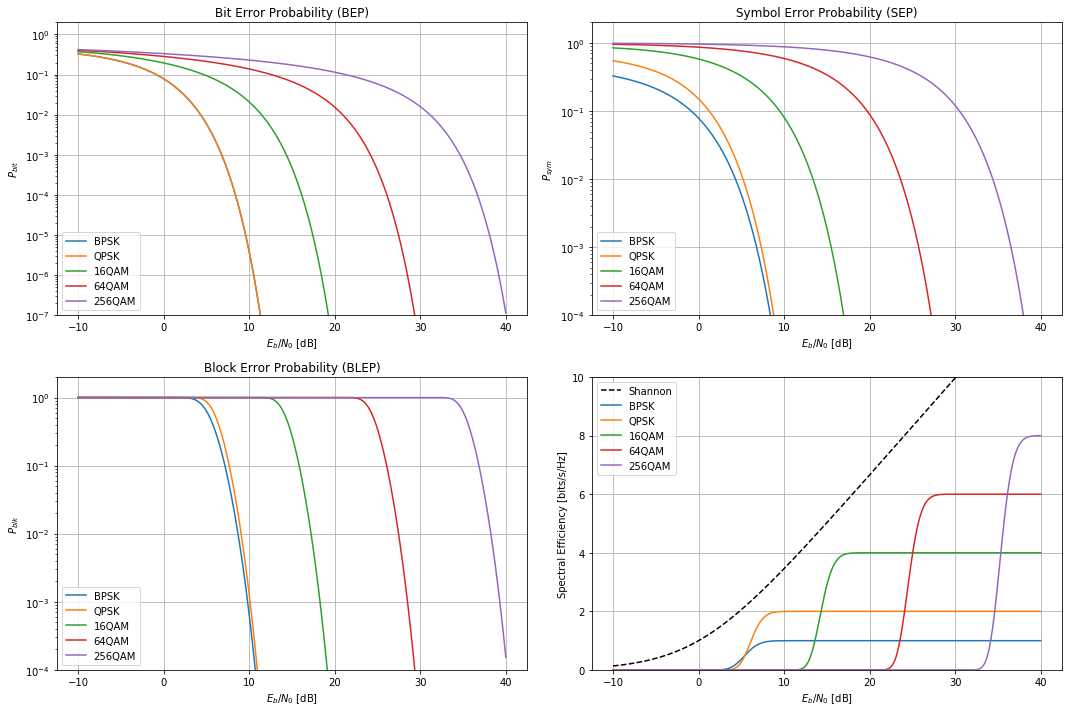

In [0]:
fig = plt.figure(figsize=[15,10])

plt.subplot(2,2,1)
for str1 in df_bep.columns:
    plt.semilogy(SINR_dB, df_bep[str1])
plt.grid()
plt.legend(loc='lower left')
plt.ylim([1e-7, 2])
plt.title('Bit Error Probability (BEP)')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('$P_{bit}$');

plt.subplot(2,2,2)
for str1 in df_sep.columns:
    plt.semilogy(SINR_dB, df_sep[str1])
plt.grid()
plt.legend(loc='lower left')
plt.ylim([1e-4, 2])
plt.title('Symbol Error Probability (SEP)')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('$P_{sym}$');

plt.subplot(2,2,3)
for str1 in df_blep.columns:
    plt.semilogy(SINR_dB, df_blep[str1])
plt.ylim([1e-4, 2])
plt.grid()
plt.legend(loc='lower left')    
plt.title('Block Error Probability (BLEP)')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('$P_{blk}$')

plt.subplot(2,2,4)
plt.plot(SINR_dB, f_shannon_cap(SINR_dB), 'k--', label = 'Shannon')
for str1 in df_Th.columns:
    plt.plot(SINR_dB, df_Th[str1], label=str1)
plt.grid()
plt.legend()
plt.ylim([0, 10])
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('Spectral Efficiency [bits/s/Hz]')

plt.tight_layout()

## BER, BLER and PER for QAM modulation under AWGN Channel

## BEP and SEP for coding under AWGN Channels

### Compute BEP and SEP for BPSK and QPSK

In [0]:
df1_bep, df1_sep = pd.DataFrame(), pd.DataFrame()

str0 = 'BPSK'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=2)

str0 = 'QPSK'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=4)

str0 = 'BPSK_diff'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=2, data_enc='diff')

str0 = 'QPSK_diff'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=4, data_enc='diff')

str0 = 'BPSK_non'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=2, data_enc='nondiff')

str0 = 'QPSK_non'
df1_bep[str0], df1_sep[str0] = fun_ber_awgn(SINR_dB, mod='psk', M=4, data_enc='nondiff')

### Plot BEP and SEP for BPSK and QPSK

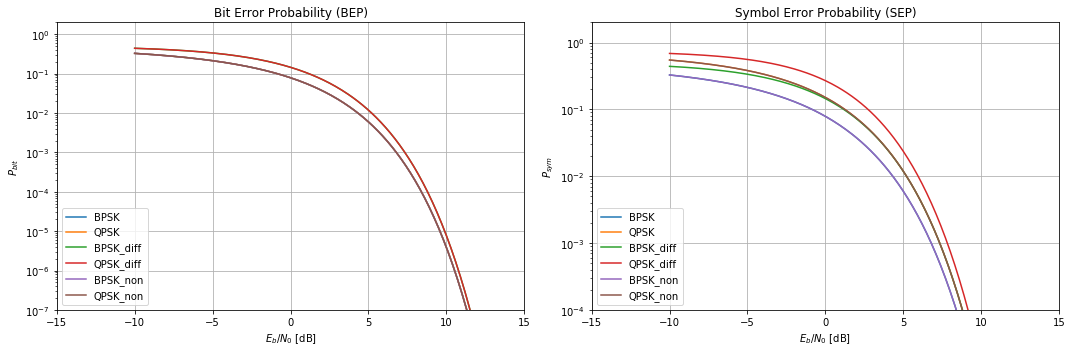

In [0]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
for str1 in df1_bep.columns:
    plt.semilogy(SINR_dB, df1_bep[str1])
plt.grid()
plt.legend(loc='lower left')
plt.xlim([-15, 15])
plt.ylim([1e-7, 2])
plt.title('Bit Error Probability (BEP)')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('$P_{bit}$');

plt.subplot(1,2,2)
for str1 in df1_sep.columns:
    plt.semilogy(SINR_dB, df1_sep[str1])
plt.grid()
plt.legend(loc='lower left')
plt.xlim([-15, 15])
plt.ylim([1e-4, 2])
plt.title('Symbol Error Probability (SEP)')
plt.xlabel('$E_b/N_0$ [dB]')
plt.ylabel('$P_{sym}$');

plt.tight_layout()

# BER, BLER and Throughput for different MCS under AWGN Channel

## Load CQI tables

In [0]:
tmp1 = fun_table_cqi(1)
tmp2 = fun_table_cqi(2)
tmp3 = fun_table_cqi(3)

df_CQI = pd.concat([tmp1, tmp2, tmp3], keys=('CQI_1', 'CQI_2', 'CQI_3'))

In [0]:
df_CQI.head()

modulation  code_rate  efficiency
      CQI index                                     
CQI_1 0          out of range        NaN         NaN
      1                  QPSK       78.0      0.1523
      2                  QPSK      120.0      0.2344
      3                  QPSK      193.0      0.3770
      4                  QPSK      308.0      0.6016

In [0]:
#n = 1024
#for k2 in range(1,len(df)):
#    k = df['code_rate'][k2].astype(int)
#    print(k)
#    #print(((not np.isscalar(k)) or (not isinstance(k, (int, np.uint))) or np.isnan(k) or np.isinf(k) or k>n))
#    print((not np.isscalar(k)),  isinstance(k, int) , np.isnan(k) , np.isinf(k) , k>n, k<=0 )

## Compute BER and BLER for diffrent MCS under AWGN channel

### Function for computing BER and SER

In [0]:
def fun_ber_cqi(EbN0dB, df_CQI, df_Qm, k3=1):
    str0 = 'CQI_' + str(k3)
    df = df_CQI.loc[str0]
    tmp1, tmp2 = pd.DataFrame(), pd.DataFrame()
    for k2 in range(1,len(df)):
        code_rate = df.code_rate[k2].astype(int)
        str1 = df.modulation[k2].strip()
        str2 = str1 + '_' + str(code_rate)
        str3 = 'MCS_' + str(k2)
        M = df_Qm.mod_order[df_Qm.modulation==str1].values[0]
        tmp1[str3], tmp2[str3] = fun_ber_coding(EbN0dB, 'block', 'hard', 1024, code_rate, 1024-code_rate, 'qam', M)
    return tmp1, tmp2

In [0]:
tmp1a, tmp1b = fun_ber_cqi(SINR_dB, df_CQI, df_Qm, k3=1)
tmp2a, tmp2b = fun_ber_cqi(SINR_dB, df_CQI, df_Qm, k3=2)
tmp3a, tmp3b = fun_ber_cqi(SINR_dB, df_CQI, df_Qm, k3=3)

df_MCS_BEP = pd.concat([tmp1a, tmp2a, tmp3a], keys=('CQI_1', 'CQI_2', 'CQI_3'))
df_MCS_SEP = pd.concat([tmp1b, tmp2b, tmp3b], keys=('CQI_1', 'CQI_2', 'CQI_3'))

df_MCS_BLEP = 1 - (1 - df_MCS_SEP)**(12*14)


## Compute Throughput

In [0]:
tmp1 = fun_throughput(df_CQI.loc['CQI_1'], df_MCS_BLEP.loc['CQI_1'])
tmp2 = fun_throughput(df_CQI.loc['CQI_2'], df_MCS_BLEP.loc['CQI_2'])
tmp3 = fun_throughput(df_CQI.loc['CQI_3'], df_MCS_BLEP.loc['CQI_3'])

df_throughput = pd.concat([tmp1, tmp2, tmp3], keys=('CQI_1', 'CQI_2', 'CQI_3'))

### Function for finding $E_s/N_0$ [dB]

In [0]:
def fun_EsN0dB(EbN0dB, df_CQI1, df_Qm, list_MCS=df_MCS_BLEP.columns.values):
    EbN0 = 10**(EbN0dB/10)
    df = pd.DataFrame()
    for k1 in range(len(list_MCS)):
        str1 = df_CQI1.modulation[k1+1].strip()
        str2 = list_MCS[k1]
        n_bits = df_Qm.n_bits[df_Qm.modulation==str1].values[0]
        df[str2] = 10*np.log10(n_bits * EbN0)
        
    return df

In [0]:
tmp1 = fun_EsN0dB(SINR_dB, df_CQI.loc['CQI_1'], df_Qm)
tmp2 = fun_EsN0dB(SINR_dB, df_CQI.loc['CQI_2'], df_Qm)
tmp3 = fun_EsN0dB(SINR_dB, df_CQI.loc['CQI_3'], df_Qm)

df_EsN0dB = pd.concat([tmp1, tmp2, tmp3], keys=('CQI_1', 'CQI_2', 'CQI_3'))#df_Qm.head()

## Plot KPI's

### Function for plotting different error rates

In [0]:
def plot_error_prob(df, df_EsN0dB, str_t, str_y, str_x):
    
    plt.figure(figsize=[14,5])
    for k3 in range(3):
        str0 = 'CQI_' + str(k3+1)
        df0 = df.loc[str0]
        df1 = df_EsN0dB.loc[str0]
        plt.subplot(1,3,k3+1)
        for k2 in range(len(df0.columns)):
            str2 = df.columns[k2]
            plt.semilogy(df1.iloc[:,k2], df0.iloc[:,k2], label=str2)
                    
        plt.xlabel(str_x)
        plt.ylabel(str_y)
        plt.title(str_t);
        plt.xlim([-6, 26])
        plt.ylim([1e-6, 2])
        plt.grid()
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(0.93, 0.5), frameon=True,
               bbox_transform=fig.transFigure)


### Plot BEP for different MCS

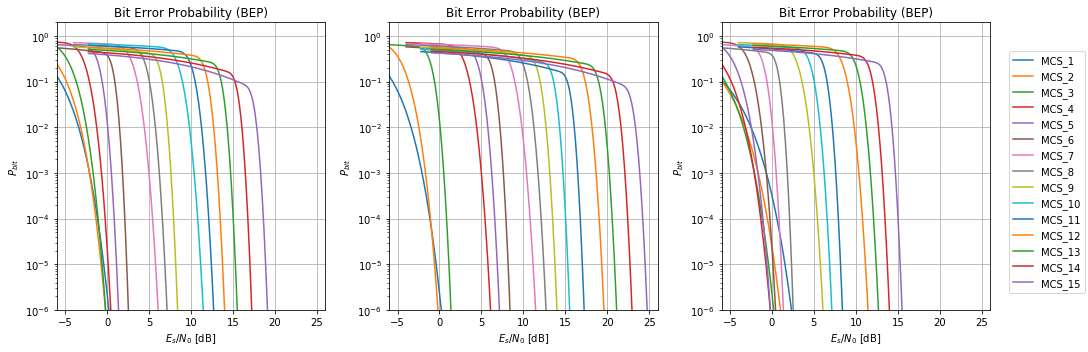

In [0]:
str_t = 'Bit Error Probability (BEP)'
str_y = '$P_{bit}$'
str_x = '$E_s/N_0$ [dB]'

plot_error_prob(df_MCS_BEP, df_EsN0dB, str_t, str_y, str_x)

### Plot SEP for different MCS

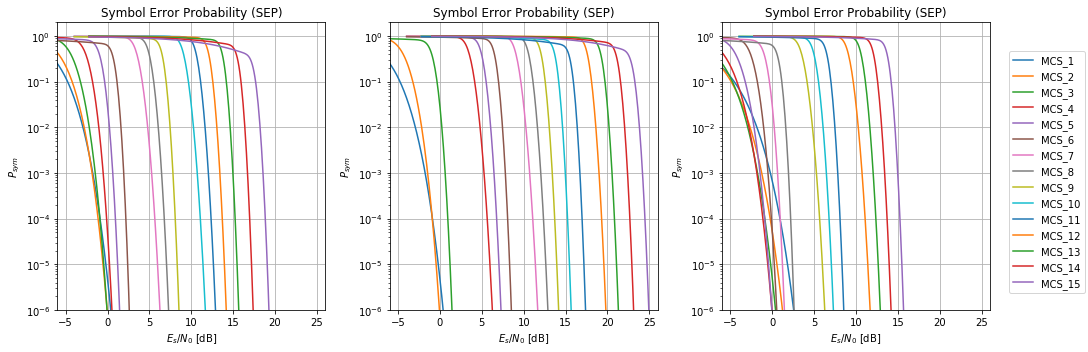

In [0]:
str_t = 'Symbol Error Probability (SEP)'
str_y = '$P_{sym}$'
str_x = '$E_s/N_0$ [dB]'

plot_error_prob(df_MCS_SEP, df_EsN0dB, str_t, str_y, str_x)

### Plot BLEP for different MCS

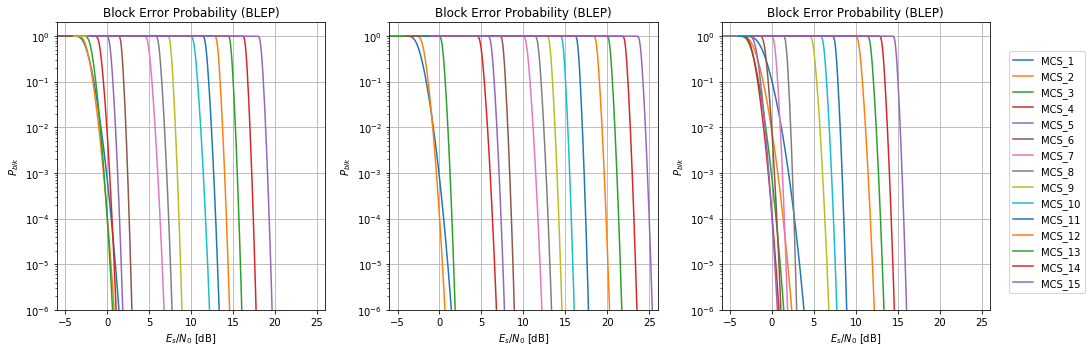

In [0]:
str_t = 'Block Error Probability (BLEP)'
str_y = '$P_{blk}$'
str_x = '$E_s/N_0$ [dB]'

plot_error_prob(df_MCS_BLEP, df_EsN0dB, str_t, str_y, str_x)

### Plot Throughput for different MCS

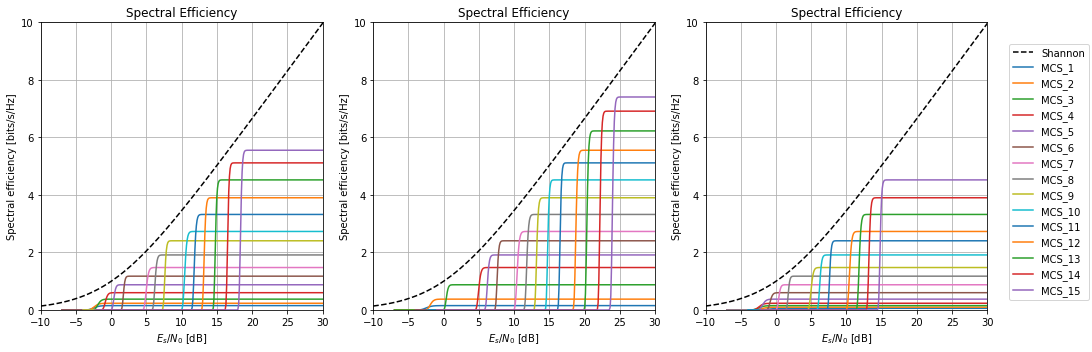

In [0]:
df = df_throughput
str_t = 'Spectral Efficiency'
str_y = 'Spectral efficiency [bits/s/Hz]'
str_x = '$E_b/N_0$ [dB]'

plt.figure(figsize=[14,5])
for k3 in range(3):
    str0 = 'CQI_' + str(k3+1)
    df0 = df.loc[str0]
    df1 = df_EsN0dB.loc[str0]
    plt.subplot(1,3,k3+1)
    plt.plot(SINR_dB, f_shannon_cap(SINR_dB),'k--', label='Shannon')
    for k2 in range(len(df0.columns)):
        str2 = df.columns[k2]
        plt.plot(df1.iloc[:,k2], df0.iloc[:,k2], label=str2)
                    
    plt.xlabel('$E_s/N_0$ [dB]')
    plt.ylabel(str_y)
    plt.title(str_t);
    plt.xlim([-10, 30])
    plt.ylim([0, 10])
    plt.grid()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(0.93, 0.5), frameon=True,
           bbox_transform=fig.transFigure)

# Finished